# Spline interpolation with Green's functions - 1D

##### References

* Davis, J. C., 2002. Statistics and Data Analysis in Geology. 3rd edition, John Wiley & Sons, ISBN 0-47 1-1 7275-8.

* Wessel, Paul. 2009. “A General-Purpose Green’s Function-Based Interpolator.” Computers & Geosciences 35 (6): 1247–54. https://doi.org/10.1016/j.cageo.2008.08.012.

## 1D interpolation

The cells below present an implementation using the 1D Cartesian Green's functions (Table 1 of notebook `greens_interp_theory`) to interpolate a data set of magnesium concentrations given as a function of distance upstream from a river mouth (Davis, 2002, Table 4-2, p. 164). The trend term $\mathbf{s}(\mathbf{q})$ (equation 5 of notebook `greens_interp_theory`) is not considered in this example.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
distance, mg = np.loadtxt('interpolation_sample_data/magnesium_concentration.txt', unpack=True)

In [3]:
distance

array([    0.,  1820.,  2542.,  2889.,  3460.,  4586.,  6020.,  6841.,
        7232., 10903., 11098., 11922., 12530., 14065., 14937., 16244.,
       17632., 19002., 20860., 22471.])

In [4]:
mg

array([6.44, 8.61, 5.24, 5.73, 3.81, 4.05, 2.95, 2.57, 3.37, 3.84, 2.86,
       1.22, 1.09, 2.36, 2.24, 2.05, 2.23, 0.42, 0.87, 1.26])

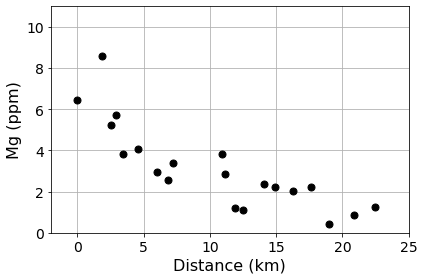

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, )

ax.plot(0.001*distance, mg, 'ko', markersize=7)
ax.set_xlabel('Distance (km)', fontsize=16)
ax.set_ylabel('Mg (ppm)', fontsize=16)
ax.set_xlim(-2, 25)
ax.set_ylim(0, 11)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.grid()
plt.tight_layout()
plt.show()

In [6]:
def G_1D(p, t=0, p_interp=None):
    '''
    Compute matrix G formed by 1D Cartesian Green's functions.
    
    Parameters
    ----------
    p : array 1D
        Vector with N coordinates.

    t : float
        Positive scalar, in the interval [0, 1[ , controlling the
        tension in spline surface.

    p_interp : array 1D
        Vector with N interpolation coordinates.

    Returns
    -------
    G : array 2D
        Matrix of Green's functions.
    '''

    p = np.asarray(p)
    assert p.ndim == 1, 'p must be a vector'
    assert p.size > 2, 'p must have more than two elements'
    assert np.isscalar(t), 't must be a scalar'
    assert (t >= 0) and (t < 1), 't must be greater than or equal to zero and lower lower than one' 

    tau = np.sqrt(t/(1-t))

    if p_interp is not None:
        p_interp = np.asarray(p_interp)
        assert p_interp.ndim == 1, 'p_interp must be a vector'
        assert p_interp.size > 2, 'p_interp must have more than two elements'
        y = p_interp
    else:
        y = p
    
    G = np.empty((y.size, p.size))
    if tau == 0:
        for j, pj in enumerate(p):
            r = np.abs(y - pj)
            G[:,j] = r**3
    else:
        for j, pj in enumerate(p):
            r = np.abs(y - pj)
            G[:,j] = np.exp(-tau*r) + tau*r - 1

    return G

### Estimate 1D spline coefficients

In [7]:
# G matrix without tension
G1D_no_tension = G_1D(distance, t=0)

In [8]:
# Coefficients without tension
coeffs_no_tension = np.linalg.solve(G1D_no_tension, mg)

In [9]:
# G matrix with tension
G1D_tension = G_1D(distance, t=0.000025)

In [10]:
# Coefficients with tension
coeffs_tension = np.linalg.solve(G1D_tension, mg)

### Interpolate 1D data

In [11]:
# Interpolation coordinates
distance_interp = np.linspace(-2000, 25000, 60)

In [12]:
# Compute interpolated data without tension
G1D_no_tension_interp = G_1D(distance, t=0, p_interp=distance_interp)
y_no_tension_interp = np.dot(G1D_no_tension_interp, coeffs_no_tension)

In [13]:
# Compute interpolated data with tension
G1D_tension_interp = G_1D(distance, t=0.000025, p_interp=distance_interp)
y_tension_interp = np.dot(G1D_tension_interp, coeffs_tension)

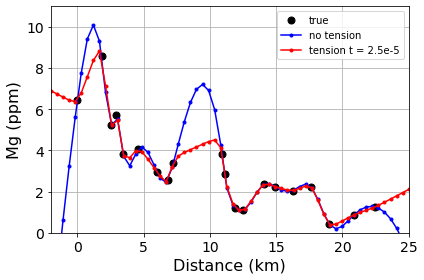

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, )

ax.plot(0.001*distance, mg, 'ko', markersize=7, label='true')
ax.plot(0.001*distance_interp, y_no_tension_interp, 'b.-', label='no tension')
ax.plot(0.001*distance_interp, y_tension_interp, 'r.-', label='tension t = 2.5e-5')
ax.set_xlabel('Distance (km)', fontsize=16)
ax.set_ylabel('Mg (ppm)', fontsize=16)
ax.set_xlim(-2, 25)
ax.set_ylim(0, 11)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.legend(loc='best')
ax.grid()
plt.tight_layout()
plt.show()